In [42]:
import os
import numpy as np
import pandas as pd
import jax.numpy as jnp
from jax.lax import scan
from jax import vmap, grad
from datetime import datetime, timedelta

from functools import partial
from scipy.optimize import minimize

from tqdm.notebook import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

import matplotlib.pyplot as plt

In [43]:
import jax
jax.config.update('jax_platform_name', 'cpu')

In [45]:
DATA = '../data/interim/climatena_1990-2020_monthly_long.csv'
df = pd.read_csv(DATA)[['PLOT_ID', 'PERIOD', 'PPT', 'EREF']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4522032 entries, 0 to 4522031
Data columns (total 4 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   PLOT_ID  int64 
 1   PERIOD   object
 2   PPT      int64 
 3   EREF     int64 
dtypes: int64(3), object(1)
memory usage: 138.0+ MB


In [46]:
precip = pd.pivot(df.reset_index(), index='PLOT_ID', columns='PERIOD', values='PPT')
evap = pd.pivot(df.reset_index(), index='PLOT_ID', columns='PERIOD', values='EREF')

precip

PERIOD,1990-01,1990-02,1990-03,1990-04,1990-05,1990-06,1990-07,1990-08,1990-09,1990-10,...,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12
PLOT_ID,,,,,,,,,,,,,,,,,,,,,
60101550679,400,323,151,74,284,56,18,61,16,141,...,106,127,302,82,3,4,88,123,349,416
60101551744,306,239,140,69,195,57,22,62,9,156,...,120,107,244,70,5,8,92,108,271,303
60101551969,429,315,146,73,275,59,20,65,16,136,...,103,124,288,84,4,5,84,123,342,432
60101552953,454,344,163,75,283,59,20,77,16,180,...,123,129,316,82,4,6,99,139,385,461
60101553315,568,437,201,106,450,88,39,125,25,216,...,138,181,472,128,8,9,133,197,500,598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530906599117,108,71,24,48,131,120,47,47,3,64,...,42,20,131,132,25,11,35,76,63,97
530907152174,158,87,115,170,123,48,16,30,4,157,...,84,53,192,88,12,13,39,105,240,136
530907170686,140,86,117,166,115,48,16,30,4,154,...,85,51,179,85,11,12,38,100,225,131


In [10]:
SOIL_OBS = '../data/interim/NASA_SMAP_soil_moisture.csv'
soil_obs = pd.read_csv(SOIL_OBS)
soil_obs = soil_obs.loc[soil_obs['PERIOD'].isin(precip.columns)]
obs = pd.pivot(soil_obs, index='PLOT_ID', columns='PERIOD', values='SMP')
obs.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 12027 entries, 60101550679.0 to 530907572668.0
Data columns (total 69 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   2015-04  12027 non-null  float64
 1   2015-05  12027 non-null  float64
 2   2015-06  12027 non-null  float64
 3   2015-07  12027 non-null  float64
 4   2015-08  12027 non-null  float64
 5   2015-09  12027 non-null  float64
 6   2015-10  12021 non-null  float64
 7   2015-11  12027 non-null  float64
 8   2015-12  12027 non-null  float64
 9   2016-01  12014 non-null  float64
 10  2016-02  12002 non-null  float64
 11  2016-03  12027 non-null  float64
 12  2016-04  12027 non-null  float64
 13  2016-05  12027 non-null  float64
 14  2016-06  12027 non-null  float64
 15  2016-07  12027 non-null  float64
 16  2016-08  12027 non-null  float64
 17  2016-09  12027 non-null  float64
 18  2016-10  11992 non-null  float64
 19  2016-11  12013 non-null  float64
 20  2016-12  12024 non-null  fl

In [36]:
plots = obs.index.values.astype(int)
plots

array([ 60101550679,  60101551969,  60101552953, ..., 530907170686,
       530907182459, 530907572668])

In [91]:
# def scan(f, init, xs, length=None):
#     if xs is None:
#       xs = [None] * length
#     carry = init
#     ys = []
#     for x in xs:
#       carry, y = f(carry, x)
#       ys.append(y)
#     return carry, np.stack(ys)

# def leaky_bucket(smi, weather, smi_crit, smi_max):
#     precip, pot_evap = weather
#     k_m = 2*(smi/smi_crit) - (smi/smi_crit)**2
#     evap = pot_evap * k_m
#     smi = jnp.clip(smi + precip - evap, 0, smi_max)
#     return smi, smi

def leaky_bucket_3param(smi, weather, smi_min, smi_crit, smi_max):
    precip, pot_evap = weather
    k_m = 2*(smi/smi_crit) - (smi/smi_crit)**2
    evap = pot_evap * k_m
    smi = jnp.clip(smi + precip - evap, smi_min, smi_max)
    return smi, smi

# def scan_leaky(row, smi_crit, smi_max):
#     precip = row[:372]
#     pot_evap = row[372:]
#     weather = (precip, pot_evap)
#     partial_leaky = partial(leaky_bucket, smi_crit=smi_crit, smi_max=smi_max)
#     _, smi = scan(partial_leaky, init=smi_max, xs=weather)
#     return smi / smi_max

def scan_leaky_3param(weather, smi_min, smi_crit, smi_max):
    partial_leaky = partial(leaky_bucket_3param, smi_min=smi_min, smi_crit=smi_crit, smi_max=smi_max)
    _, smi = scan(partial_leaky, init=smi_max, xs=weather)
    return smi / smi_max

# def scan_sse(smi_params, fiacond=None):
#     smi_crit, smi_add = smi_params
#     smi_max = smi_crit + smi_add
#     X = jnp.hstack((precip.loc[fiacond].values, evap.loc[fiacond].values))
#     smi = scan_leaky(X, smi_crit, smi_max)
#     y_pred = smi[-69:]
#     y_obs = obs.loc[fiacond].values
#     return ((y_pred - y_obs)**2).sum()

def scan_sse_3param(smi_params, fiacond=None):
    smi_min, smi_crit_add, smi_max_add = smi_params
    smi_crit = smi_min + smi_crit_add
    smi_max = smi_crit + smi_max_add
    X = (precip.loc[fiacond].values, evap.loc[fiacond].values)
    smi = scan_leaky_3param(X, smi_min, smi_crit, smi_max)
    y_obs = obs.loc[fiacond].values
    y_pred = smi[-len(y_obs):]
    return ((y_pred - y_obs)**2).sum()

In [92]:
def fit_3param(idx, method='SLSQP'):
    min_sse = partial(scan_sse_3param, fiacond=idx)
    jac = grad(min_sse)
    res = minimize(min_sse, x0=(0.,150., 10.), 
                   method=method, jac=jac,
                   bounds=((0.,100.),(0.,1000.),(0.,500.))
                  )
    smi_min, smi_crit_add, smi_max_add = res.x
    smi_crit = smi_min + smi_crit_add
    smi_max = smi_crit + smi_max_add
    return idx, (smi_min, smi_crit, smi_max)

In [109]:
OVERWRITE = False
OUTFILE = '../data/interim/smi_coefs.csv'

if OVERWRITE or not os.path.exists(OUTFILE):
    results = pd.DataFrame(index=obs.index, 
                           columns=['SMI_MIN', 'SMI_CRIT', 'SMI_MAX'], 
                           dtype='Int64')
else:
    results = pd.read_csv(OUTFILE).set_index('PLOT_ID').astype('Int64')
    results.index = results.index.astype(int)

to_run = results.loc[results.SMI_MIN.isna()].index
num_jobs = len(to_run)
with tqdm(total=num_jobs) as pbar:
    CHUNK_SIZE = 40*12   # takes about 10GB of RAM for 96 (32*3) jobs, 38GB RAM for 384 (32*12) jobs
    num_chunks = int(np.ceil(num_jobs/CHUNK_SIZE))
    for i in range(num_chunks):  # chunking like this before creating processpoolexecutor to 
        failed_jobs = []
        
        with ProcessPoolExecutor(40) as executor:  # manage memory footprint involved with holding all futures
            jobs = [executor.submit(fit_3param, idx) for idx 
                    in to_run[i*CHUNK_SIZE:min(num_jobs, (i+1)*CHUNK_SIZE)]]
            for job in as_completed(jobs):
                idx, coefs = job.result()
                try:
                    update = pd.Series(coefs, 
                                       index=['SMI_MIN', 'SMI_CRIT', 'SMI_MAX']
                                      ).astype(int)
                    results.loc[idx] = update
                    pbar.update()
            
                except:
                    failed_jobs.append(idx)
                    
        with ProcessPoolExecutor(40) as executor:
            retry_jobs = [executor.submit(fit_3param, idx, method='TNC') for idx 
                          in failed_jobs]
            for job in as_completed(retry_jobs):
                idx, coefs = job.result()
                try:    
                    update = pd.Series(coefs, 
                                       index=['SMI_MIN', 'SMI_CRIT', 'SMI_MAX']
                                      ).astype(int)
                    results.loc[idx] = update
                    pbar.update()
            
                except:
                    print('Failed on', idx)
                    pbar.update()

0it [00:00, ?it/s]

In [110]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12027 entries, 60101550679 to 530907572668
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   SMI_MIN   12027 non-null  Int64
 1   SMI_CRIT  12027 non-null  Int64
 2   SMI_MAX   12027 non-null  Int64
dtypes: Int64(3)
memory usage: 411.1 KB


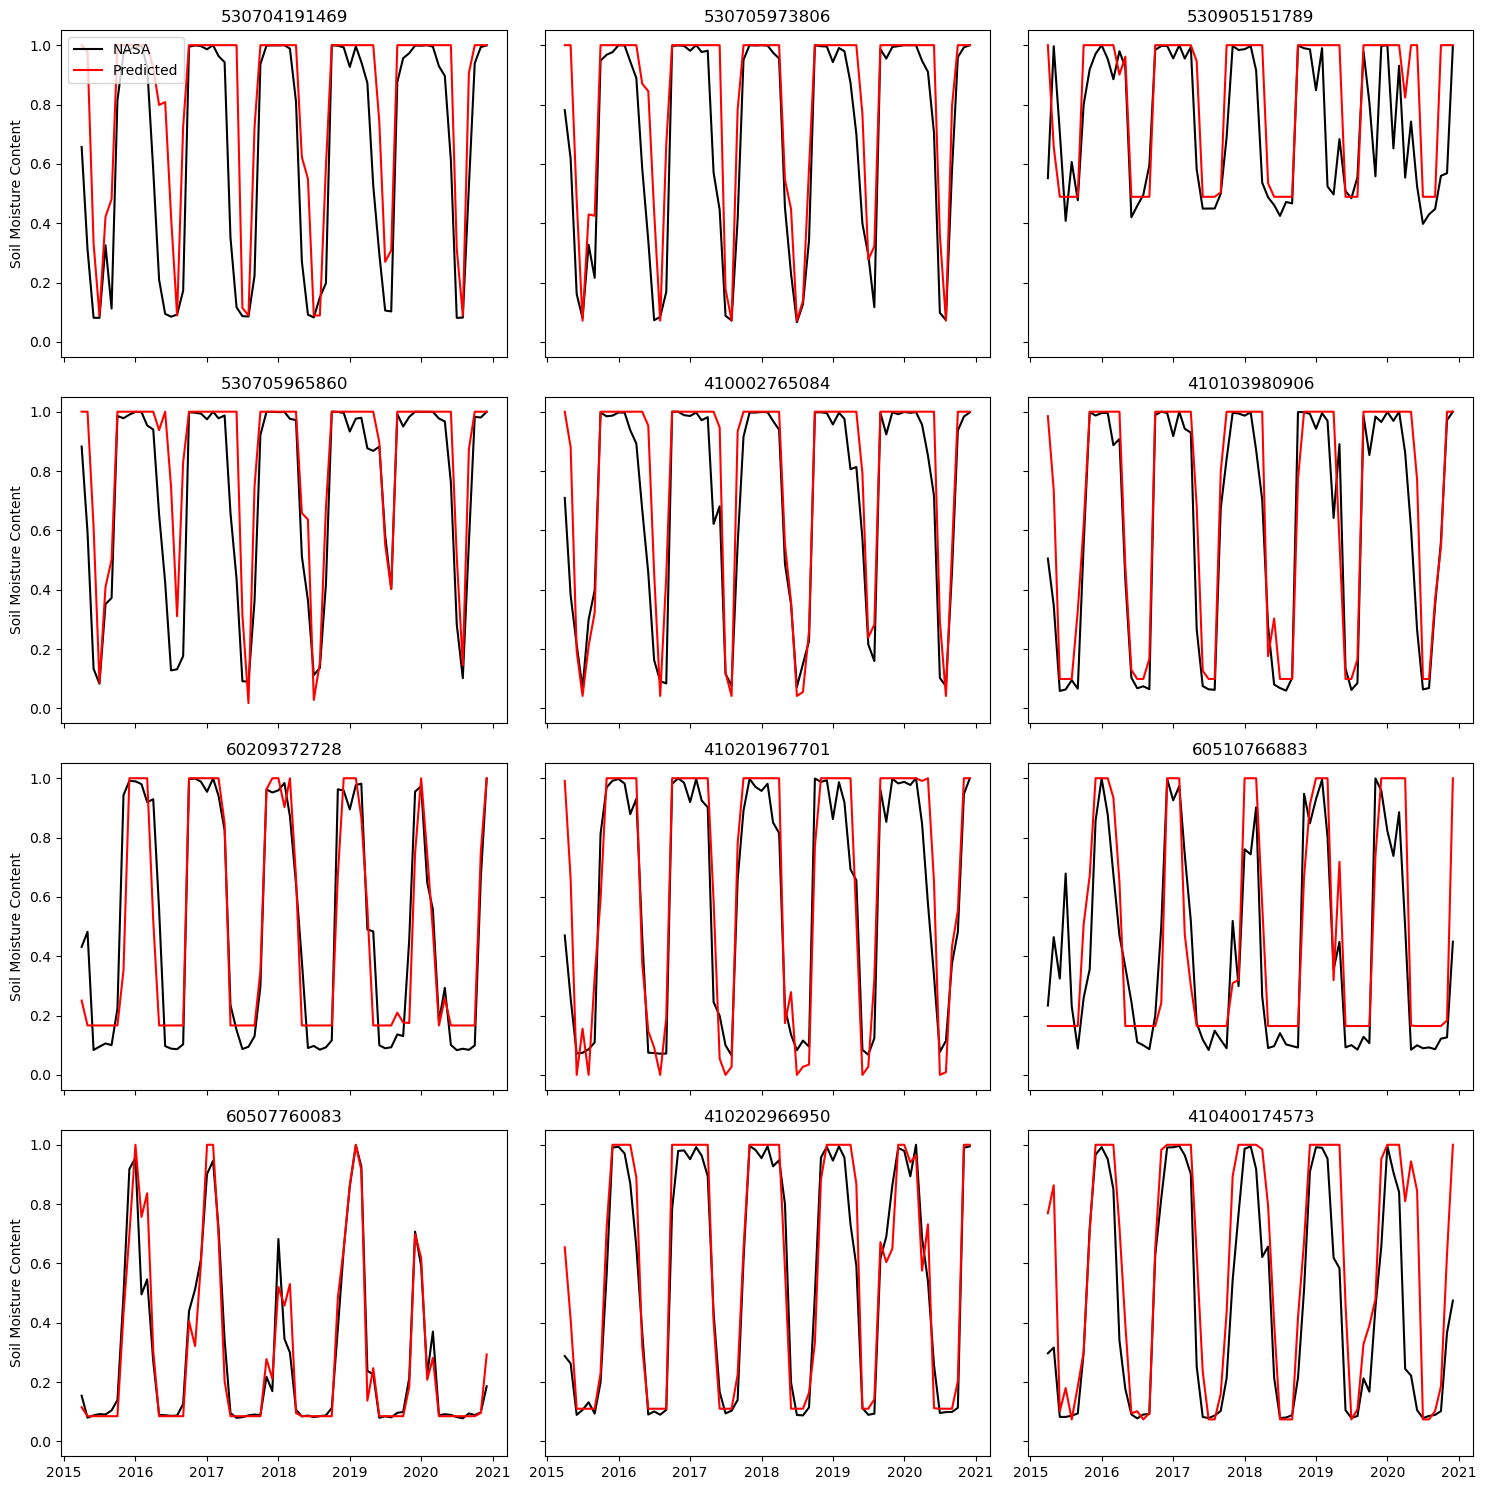

In [37]:
fig, axs = plt.subplots(4,3, figsize=(15,15), sharex=True, sharey=True)
vis_plots = np.random.choice(plots, 16)
for i in range(12):
    to_plot = vis_plots[i]
    smi_min, smi_crit, smi_max = results.loc[to_plot].values.astype(float)
    X = jnp.hstack((precip.loc[to_plot].values, evap.loc[to_plot].values))
    smi = scan_leaky_3param(X, smi_min, smi_crit, smi_max)
    y_pred = smi[-69:]
    y_obs = obs.loc[to_plot].values
    dates = obs.loc[to_plot].index.to_timestamp()
    axs.ravel()[i].plot(dates, y_obs, color='black', lw=1.5, label='NASA')
    axs.ravel()[i].plot(dates, y_pred, color='red', lw=1.5, label='Predicted')
    axs.ravel()[i].set_title(to_plot)
for ax in axs[:,0]:
    ax.set_ylabel('Soil Moisture Content')
axs[0,0].legend(loc='upper left')
plt.tight_layout()
plt.savefig('../reports/figures/example_leaky_bucket.png', dpi=300, bbox_inches='tight')
plt.show()

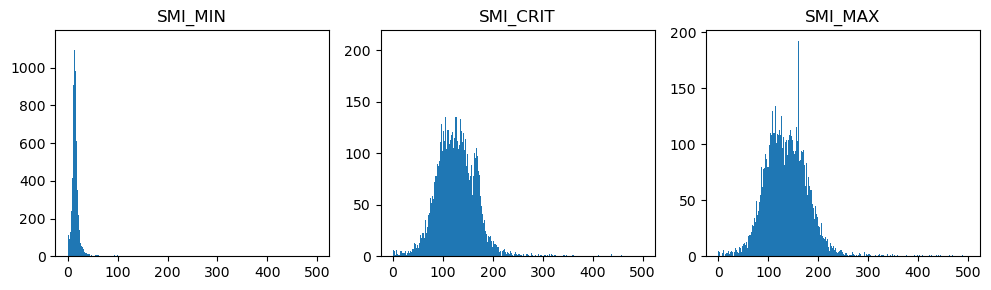

In [41]:
fig, axs = plt.subplots(1,3, figsize=(10,3))
for i, var in enumerate(['SMI_MIN', 'SMI_CRIT', 'SMI_MAX']):
    axs[i].hist(results[var], bins=np.arange(0,500))
    axs[i].set_title(var)

plt.tight_layout()
plt.show()

In [27]:
results.to_csv(OUTFILE, index=True, header=True)

In [100]:
results.iloc[0:2].index

Float64Index([60101550679.0, 60101551969.0], dtype='float64', name='PLOT_ID')

In [98]:
precip.index

Int64Index([ 60101550679,  60101551744,  60101551969,  60101552953,
             60101553315,  60101553519,  60101553771,  60101554352,
             60101554385,  60101555542,
            ...
            530906597684, 530906597921, 530906598325, 530906598619,
            530906598889, 530906599117, 530907152174, 530907170686,
            530907182459, 530907572668],
           dtype='int64', name='PLOT_ID', length=12156)

In [123]:
results.reindex(precip.index).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12156 entries, 60101550679 to 530907572668
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   SMI_MIN   12027 non-null  Int64
 1   SMI_CRIT  12027 non-null  Int64
 2   SMI_MAX   12027 non-null  Int64
dtypes: Int64(3)
memory usage: 673.5 KB


In [126]:
filled_results = results.reindex(precip.index)
for col in ['SMI_MIN', 'SMI_CRIT', 'SMI_MAX']:
    filled_results[col].fillna(results[col].mean().astype(int), inplace=True)
filled_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12156 entries, 60101550679 to 530907572668
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   SMI_MIN   12156 non-null  Int64
 1   SMI_CRIT  12156 non-null  Int64
 2   SMI_MAX   12156 non-null  Int64
dtypes: Int64(3)
memory usage: 673.5 KB


In [133]:
pred = precip.copy()
pred[:] = (scan_leaky_3param((precip.values.T, evap.values.T), 
                  filled_results['SMI_MIN'].values.astype(float), 
                  filled_results['SMI_CRIT'].values.astype(float),
                  filled_results['SMI_MAX'].values.astype(float))).T
pred = pred.stack()
pred.name = 'SOIL_MOISTURE'
pred

PLOT_ID       PERIOD 
60101550679   1990-01    1.000000
              1990-02    1.000000
              1990-03    1.000000
              1990-04    0.920647
              1990-05    1.000000
                           ...   
530907572668  2020-08    0.113333
              2020-09    0.113333
              2020-10    0.353002
              2020-11    0.679359
              2020-12    1.000000
Name: SOIL_MOISTURE, Length: 4519800, dtype: float64